In [1]:
get_ipython().magic('matplotlib inline')
get_ipython().magic('config InlineBackend.figure_format = "retina"')

import matplotlib.pyplot as pl

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
from configobj import ConfigObj
from astropy import constants as c
from astropy import units as u
import pprint

import limbdark

pp = pprint.PrettyPrinter(indent=2)

def map_int(x):
    return list(map(int, x))

def map_float(x):
    return list(map(float, x))

sys.path.append('..')
from transitfit import TransitFit
from transitfit.util import mad_outliers, get_init_params, u_to_q

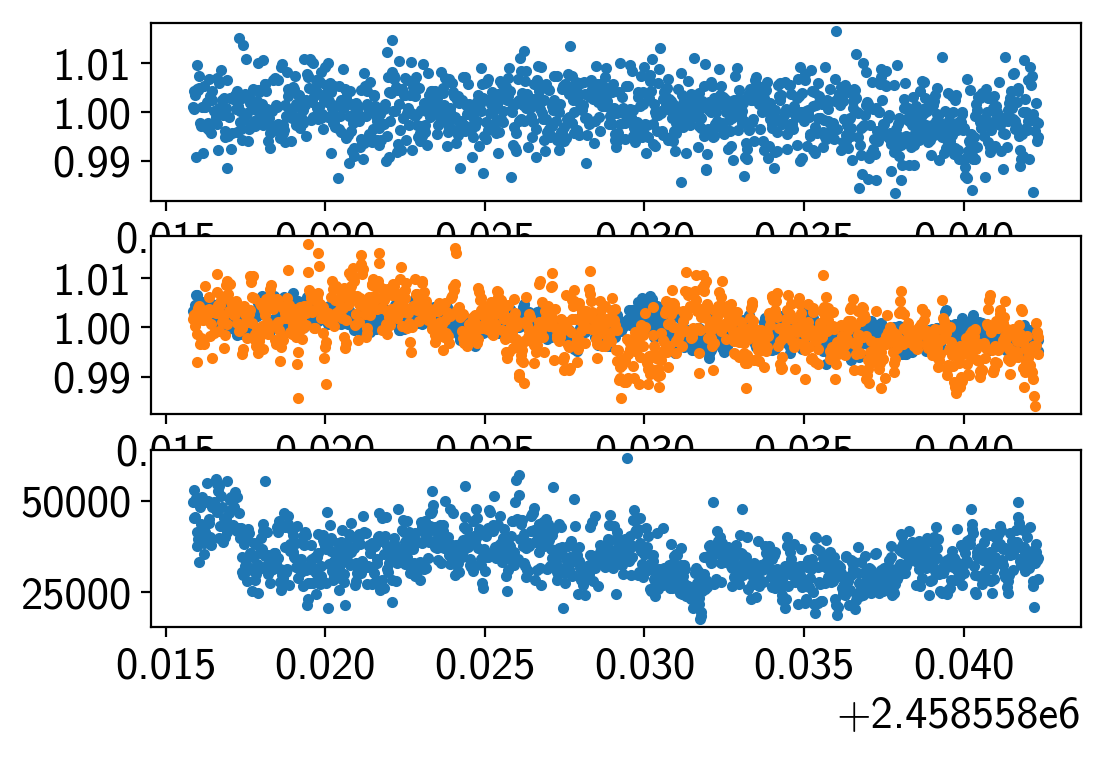

In [3]:
fp = '../data/20190315-TNT-TOI433_01-i.txt'
df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split())

time, flux, cenx, ceny, peak = df.values.T

time += 2400000.5
flux /= np.median(flux)

fig, axs = pl.subplots(3, 1)
axs[0].plot(time, flux, '.')
axs[1].plot(time, cenx/cenx.mean(), '.')
axs[1].plot(time, ceny/ceny.mean(), '.')
axs[2].plot(time, peak, '.')

0


<Container object of 3 artists>

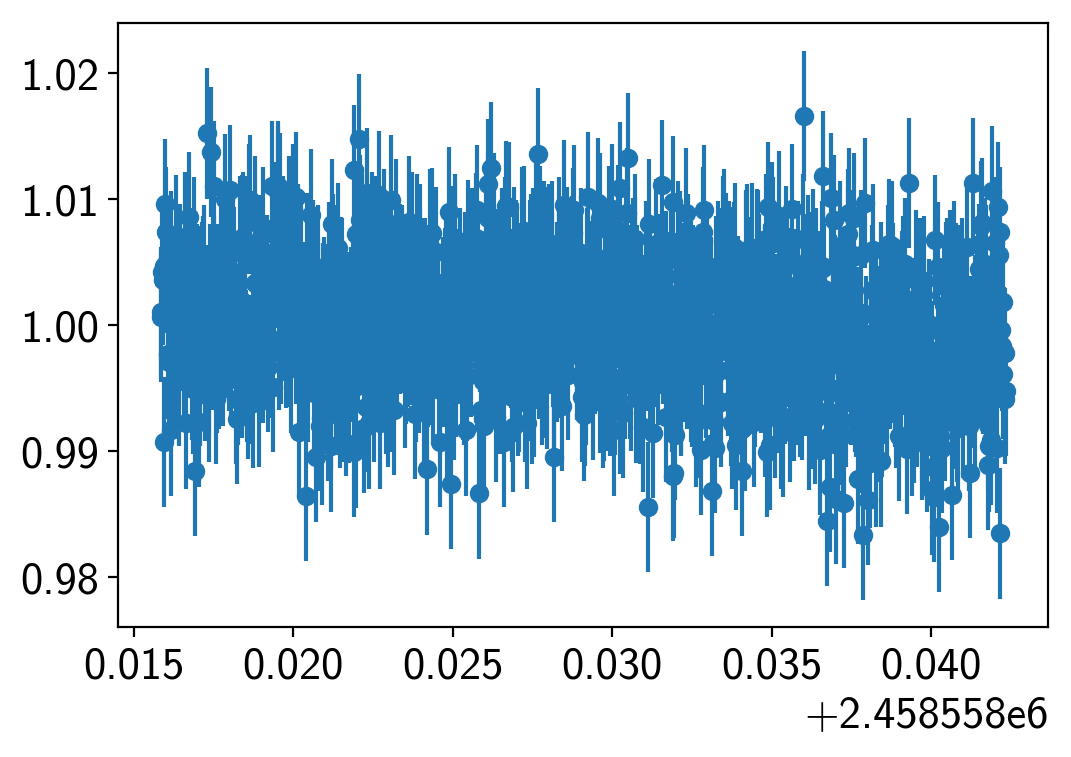

In [4]:
aux = np.c_[np.ones_like(time), time-time.min(), (time-time.min())**2, cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]
# aux = np.c_[np.ones_like(time), time-time.min(), cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]

idx = mad_outliers(flux)
print(idx.sum())

time, flux, aux = time[~idx], flux[~idx], aux[~idx]
unc = flux.std()

pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [5]:
# bin the data
##############

# fp = 'TOI-136_irsf_181007_j.csv'
# df = pd.read_csv(fp)

# idx = mad_outliers(df['flux'].values)
# print('omitting {} outliers'.format(idx.sum()))
# df = df[~idx]

# binsize_min = 5
# binsize = binsize_min / (60 * 24)
# print(np.diff(df['BJD_TDB']).mean()*86400)
# bins = np.arange(df['BJD_TDB'].min(), df['BJD_TDB'].max(), binsize)
# groups = df.groupby(np.digitize(df['BJD_TDB'], bins))
# df_binned = groups.mean()
# df = df_binned.copy()

# aux = df['airmass sky dx dy fwhm peak'.split()].values
# time, flux, unc = df['BJD_TDB flux err'.split()].values.T
# pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [7]:
band = 'i*'

planets = { 'TOI433.01': 
           { 
               'per': 1.17409,
               'rprs': 0.12,
               't0': 2458438.299,
               't14': 0.07
           }
          }

star = { 'feh': [0.0, 0.5],
            'logg': [3.73791, 0.56861198],
            'rad': [3.2681601, 0.87674499],
            'teff': [8543, 227]}

teff, logg, feh = [star.get(k) for k in 'teff logg feh'.split()]

ldp = limbdark.claret(band, teff[0], teff[1], logg[0], logg[1], feh[0], feh[1])
u1, u2 = ldp[0], ldp[2]
q1, q2 = u_to_q(u1, u2)

# logg = map_float(star['logg'])
# rad = map_float(star['rad'])
# n = 10000
# rad_s = rad[0] + np.random.randn(n) * rad[1]
# logg_s = logg[0] + np.random.randn(n) * logg[1]
# rho_s = rho(logg_s, rad_s)
# rhop = rho_s.mean(), rho_s.std()

# priors = dict(ld=ldp, rho=rhop)

pl_name = list(planets.keys())[0]
planet = planets[pl_name]
per, t0, t14, rprs = [planet.get(key) for key in 'per t0 t14 rprs'.split()]

while t0 < time.min():
    t0 += per
    
t0p = t0, 0.00045
perp = per, 0.00004
t14p = t14, 0.002
priors = dict(ld=ldp, t0=t0p, per=perp, t14=t14p)
# priors = None

init_params = get_init_params(per, t0, t14, rprs, b=0.5, q1=q1, q2=q2)
init_params['priors'] = priors
init_params['ls'] = np.log(flux.std())
pp.pprint(init_params)

{ 'b': 0.5,
  'k': 0.12,
  'ls': -5.264731899886306,
  'p': 1.17409,
  'priors': { 'ld': ( 0.2089,
                      0.018678828923353305,
                      0.2387,
                      0.022275819461719023),
              'per': (1.17409, 4e-05),
              't0': (2458558.056179987, 0.00045),
              't14': (0.07, 0.002)},
  'q1': 0.20034576,
  'q2': 0.23335567470956212,
  'r': 1.41,
  't0': 2458558.056179987,
  't14': 0.07}


In [8]:
# fit = TransitFit(init_params, pl_name, time, flux, unc=unc, aux=aux)
fit = TransitFit(init_params, pl_name, time, flux, aux=aux)

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


In [9]:
fit.fit_map()

Initial L-M least squares fit successful
[[Variables]]
    t0:   2.4586e+06 +/- 0        (0.00%) (init= 2458558)
    p:    1.17409 (fixed)
    k:    0.12 (fixed)
    r:    1.41 (fixed)
    b:    0.51197195 +/- 0        (0.00%) (init= 0.5)
    q1:   0.2003458 (fixed)
    q2:   0.2333557 (fixed)
    ls:  -5.264732 (fixed)
    c0:   0.15224642 +/- 0        (0.00%) (init= 0)
    c1:   1.57236956 +/- 0        (0.00%) (init= 0)
    c2:  -45.5596642 +/- 0        (0.00%) (init= 0)
    c3:   0.08764240 +/- 0        (0.00%) (init= 0)
    c4:  -0.23507221 +/- 0        (0.00%) (init= 0)
    c5:  -0.00426904 +/- 0        (0.00%) (init= 0)
None
Transit depth: 14400 [ppm]
Transit duration: 1.93 [h]
Log-probability: 4561.827445297973
True
[[Variables]]
    t0:   2458558 (fixed)
    p:    1.17409 (fixed)
    k:    0.12 (fixed)
    r:    1.41 (fixed)
    b:    0.59151911 (init= 0.511972)
    q1:   0.2003458 (fixed)
    q2:   0.2333557 (fixed)
    ls:  -5.30923093 (init=-5.264732)
    c0:   0.21942317 (i

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


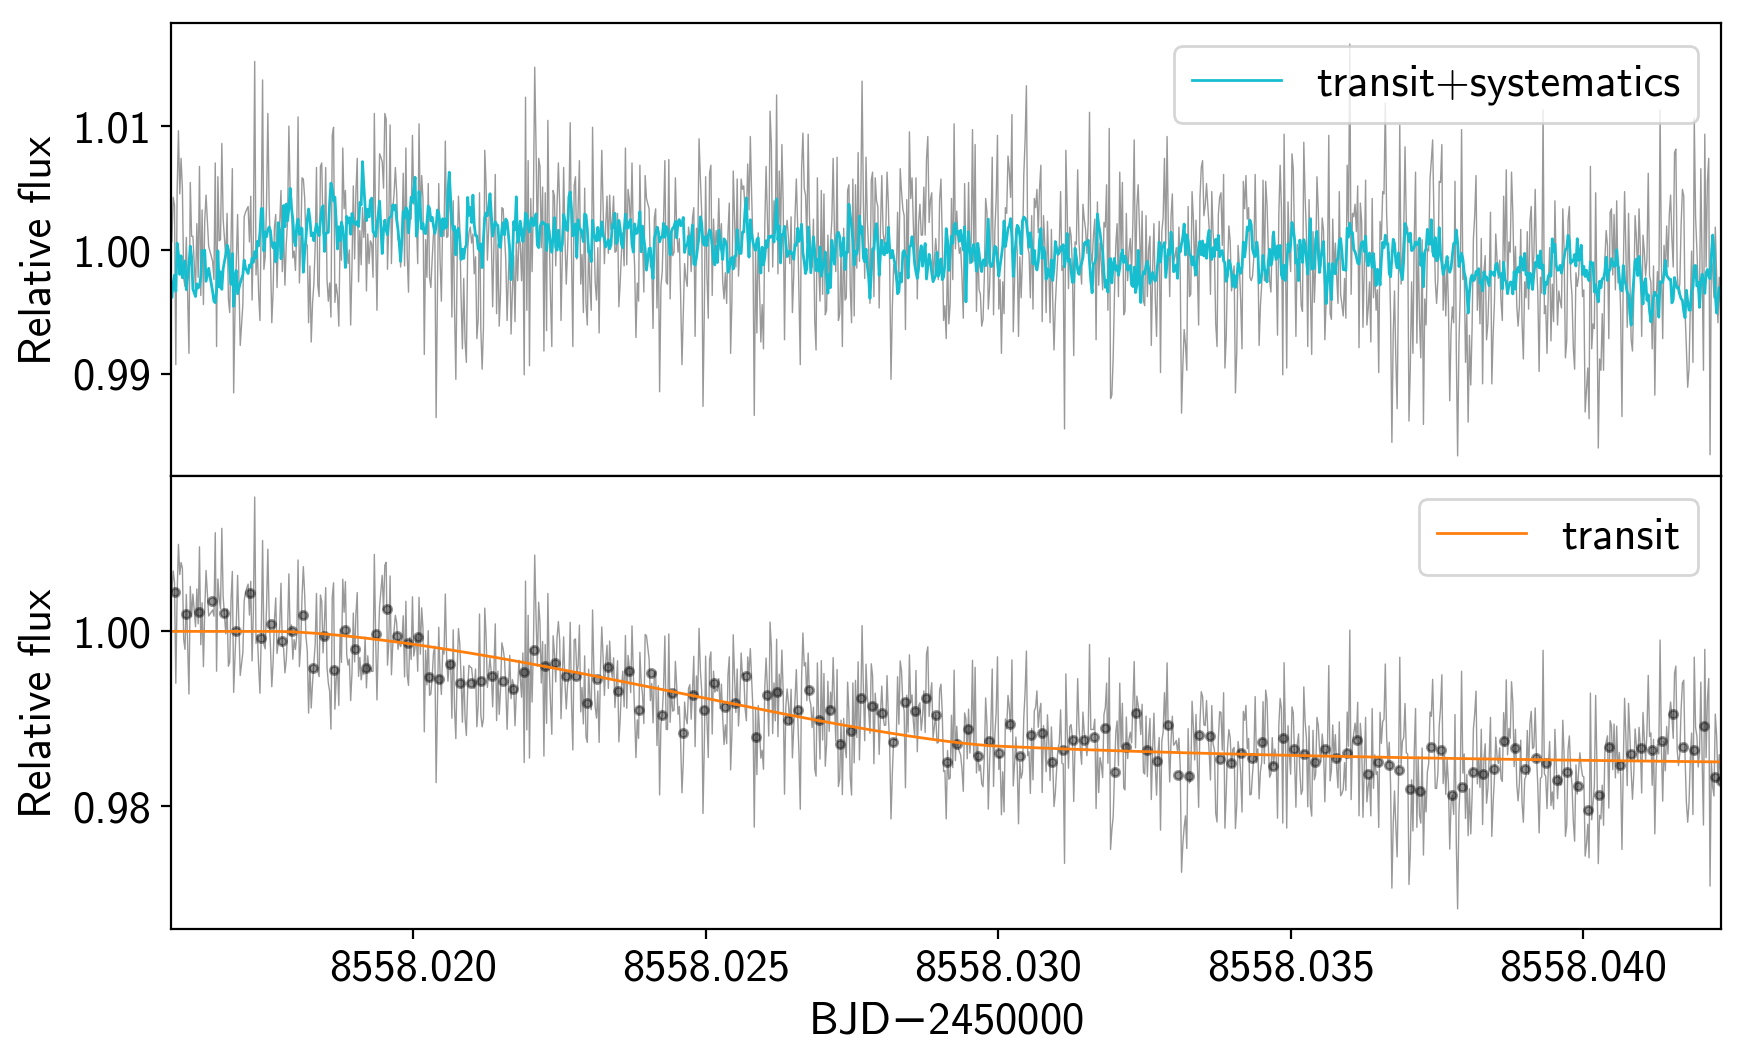

In [10]:
fit.plot_map()

In [11]:
# fit.fit_mcmc(two_stage=True)
fit.fit_mcmc(two_stage=True, steps=2000, nproc=4)

Running stage 1 MCMC (250 steps)...
Running production MCMC for 2000 steps...


../transitfit/model.py:72: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(t14, loc=t14p[0], scale=t14p[1]))
../transitfit/model.py:72: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(t14, loc=t14p[0], scale=t14p[1]))
../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))
../transitfit/model.py:72: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(t14, loc=t14p[0], scale=t14p[1]))
../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))
../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))
../transitfit/model.py:72: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(t14, loc=t14p[0], scale=t14p[1]))
../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return n

[[Variables]]
    t0:   2.4586e+06 +/- 0.000640 (0.00%) (init= 2458558)
    p:    1.17409074 +/- 4.43e-05 (0.00%) (init= 1.17409)
    k:    0.06942178 +/- 0.044392 (63.95%) (init= 0.12)
    r:    1.24728980 +/- 0.633581 (50.80%) (init= 1.41)
    b:    0.64182553 +/- 0.235916 (36.76%) (init= 0.5915191)
    q1:   0.19676360 +/- 0.025466 (12.94%) (init= 0.2003458)
    q2:   0.23294478 +/- 0.015540 (6.67%) (init= 0.2333557)
    ls:  -5.31872917 +/- 0.020217 (0.38%) (init=-5.309231)
    c0:   0.18917783 +/- 0.088083 (46.56%) (init= 0.2194232)
    c1:   0.17992059 +/- 0.698207 (388.06%) (init= 1.436776)
    c2:  -11.4180918 +/- 17.11676 (149.91%) (init=-38.10855)
    c3:   0.04893810 +/- 0.073769 (150.74%) (init= 0.04146689)
    c4:  -0.23259302 +/- 0.034634 (14.89%) (init=-0.2567199)
    c5:  -0.00529899 +/- 0.001073 (20.25%) (init=-0.004873746)
None
FIT_MCMC elapsed time: 167 sec


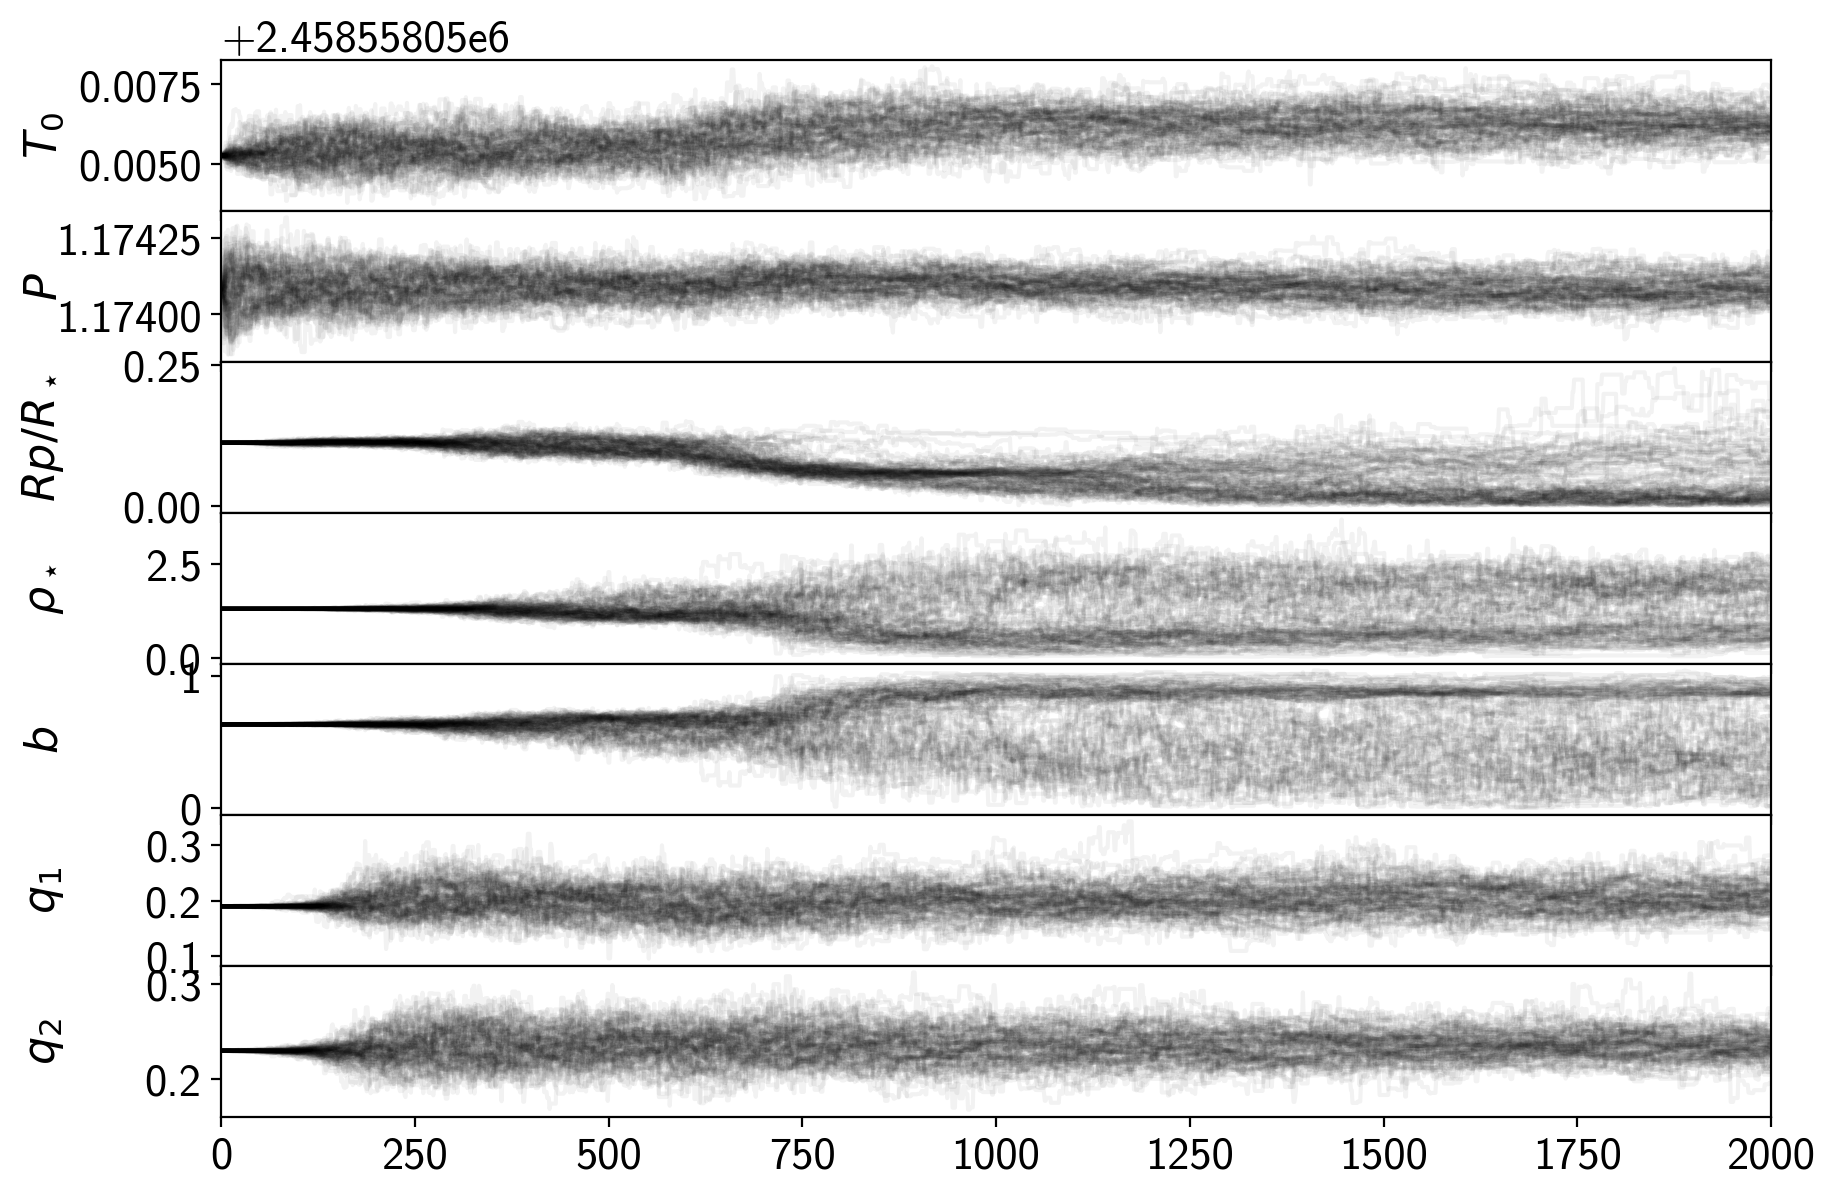

In [12]:
fit.plot_trace()

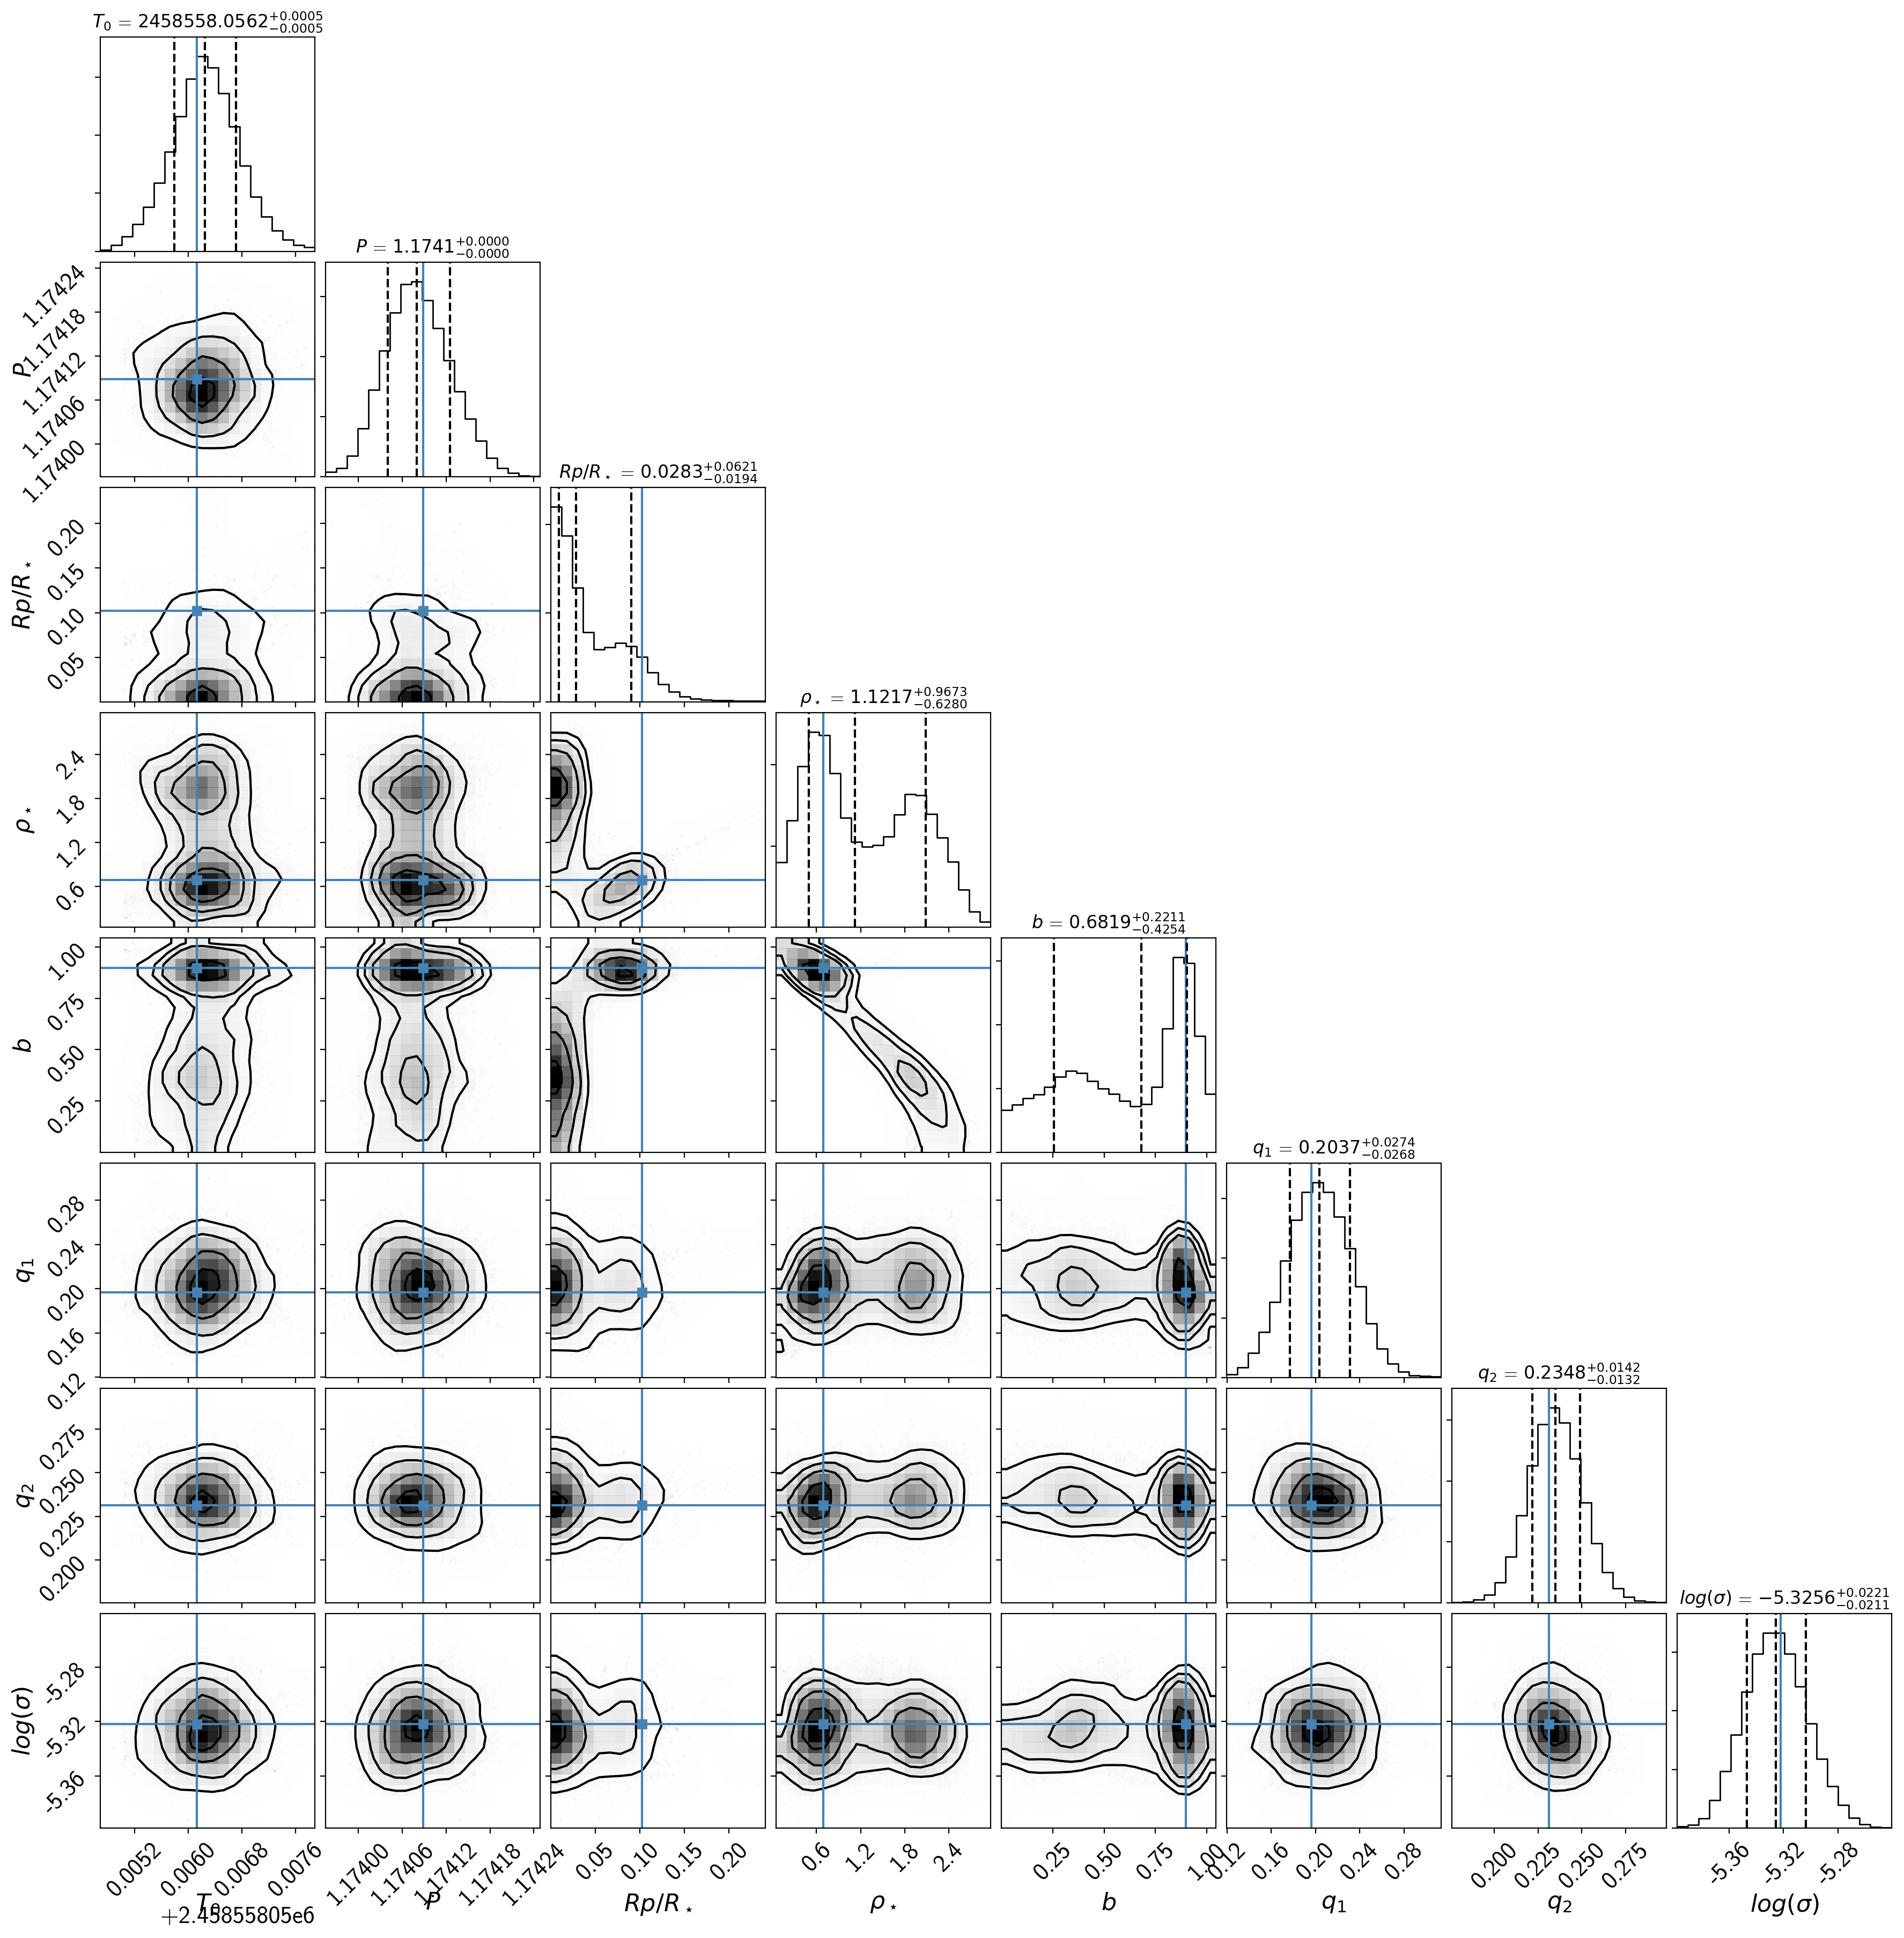

In [13]:
fit.burn_thin(burn=1500, thin=10)
fit.plot_corner()

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


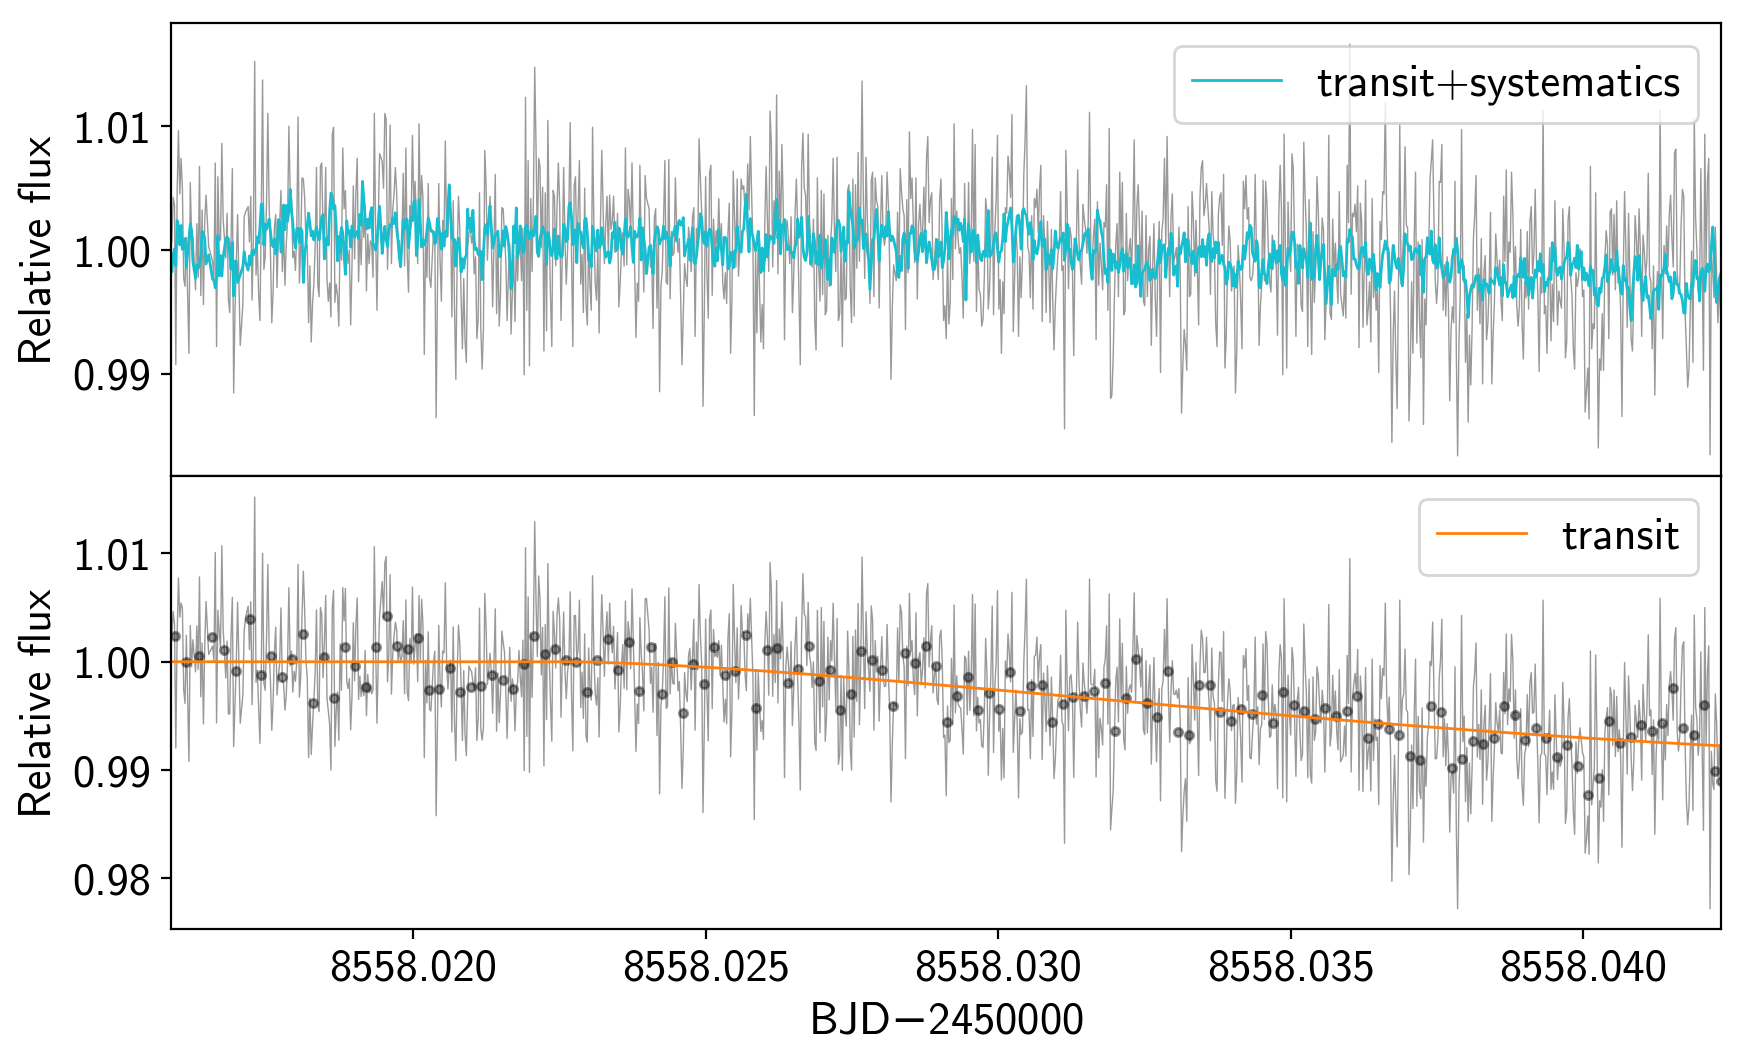

In [14]:
fit.plot_map()

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


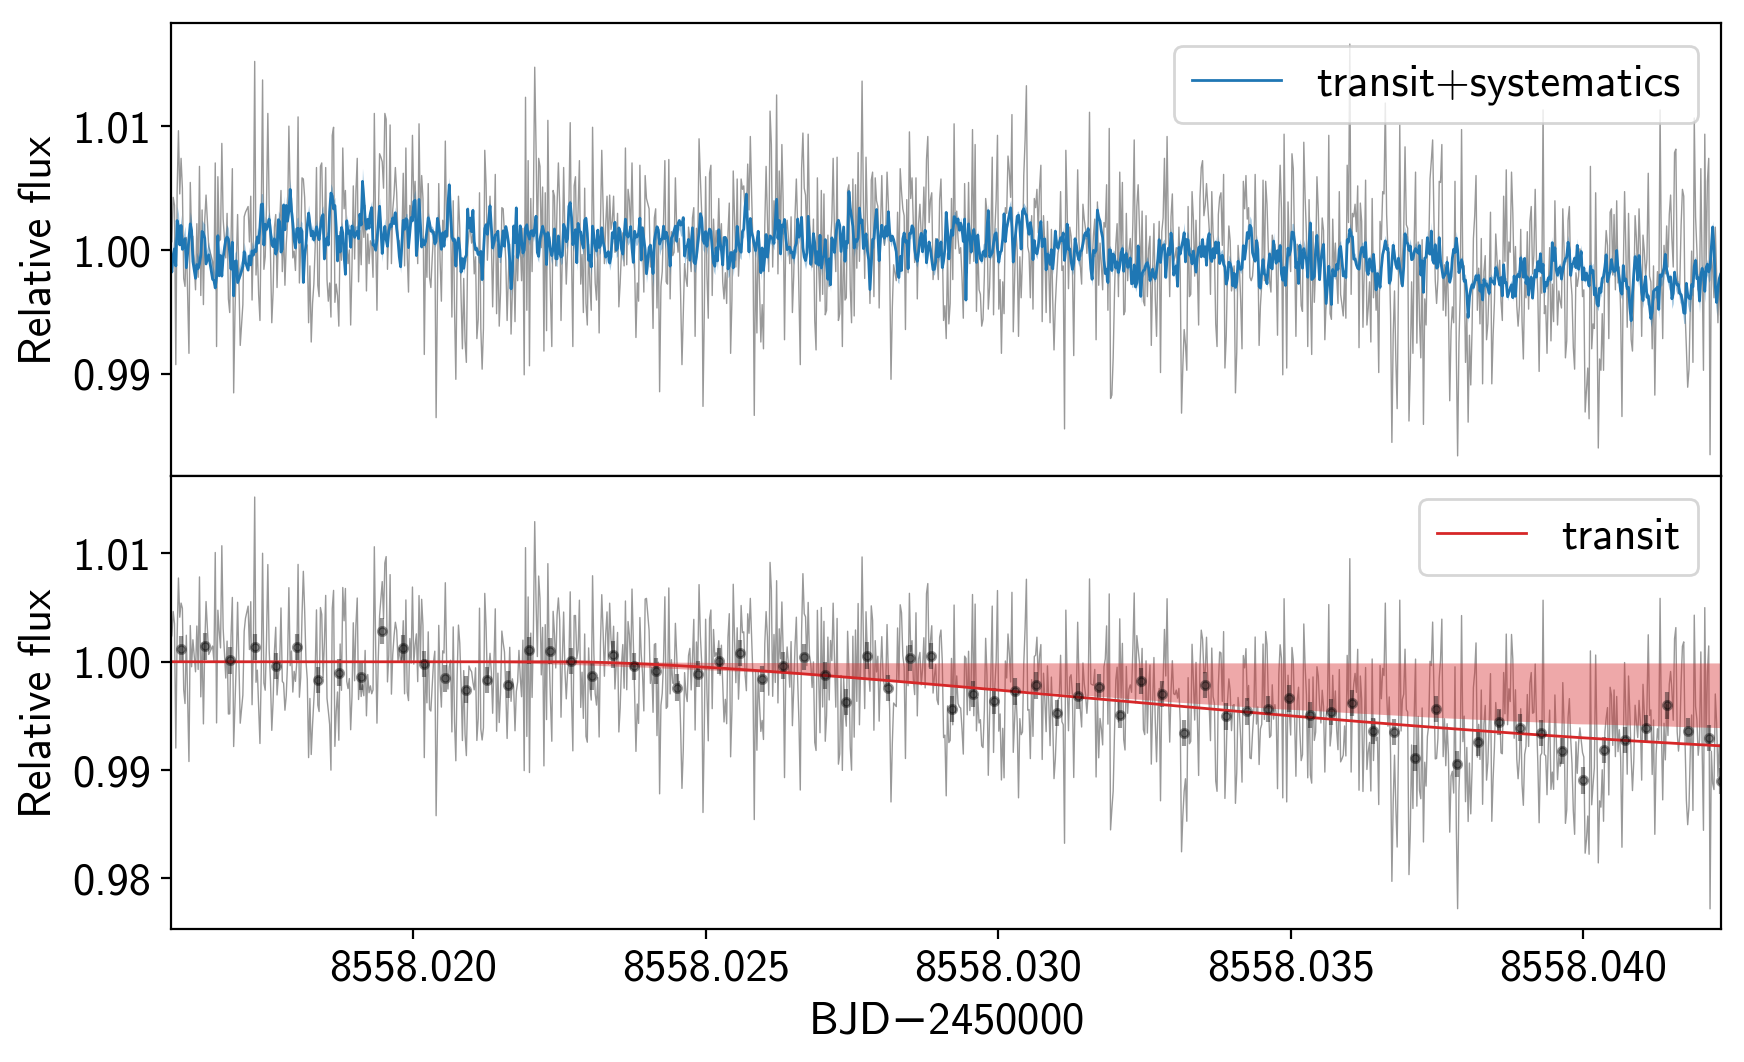

In [15]:
fig, axs = pl.subplots(2, 1, figsize=(10,6), sharex=True, sharey=False)
fit.plot_mcmc(binsize=16, c1='C0', c2='C3', sig=1, axs=axs)
# pl.setp(axs[1], ylim=(0.85,1.05))

In [16]:
fit.get_df(*star['rad']).describe()

../transitfit/util.py:79: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt( (1 - k)**2 - b**2 )


t0            p            k            r            b  \
count  5.000000e+03  5000.000000  5000.000000  5000.000000  5000.000000   
mean   2.458558e+06     1.174082     0.045143     1.249628     0.610105   
std    4.807183e-04     0.000042     0.040432     0.712489     0.296136   
min    2.458558e+06     1.173955     0.000009     0.048533     0.000062   
25%    2.458558e+06     1.174053     0.012773     0.616948     0.345908   
50%    2.458558e+06     1.174080     0.028254     1.121699     0.681939   
75%    2.458558e+06     1.174110     0.075127     1.901391     0.878942   
max    2.458558e+06     1.174249     0.240606     2.972621     1.044265   

                q1           q2           ls           c0           c1  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.203849     0.235112    -5.325220     0.147400    -0.022452   
std       0.027017     0.014070     0.021310     0.094812     0.116607   
min       0.119665     0.175635    -5.398036    -0.215052    -0.601700   
25%       0.185412     0.225570    -5.340150     0.085298    -0.097505   
50%       0.203738     0.234835    -5.325642     0.148917    -0.032632   
75%       0.223188     0.244418    -5.310738     0.211808     0.045207   
max       0.313622     0.298325    -5.240685     0.428062     0.567737   

          ...                c4           c5        rstar       pl_rad  \
count     ...       5000.000000  5000.000000  5000.000000  5000.000000   
mean      ...         -0.214785    -0.005770     3.264340    16.042856   
std       ...          0.033687     0.000779     0.894109    15.529513   
min       ...         -0.319842    -0.008835     0.302574     0.003321   
25%       ...         -0.238186    -0.006293     2.646345     4.312110   
50%       ...         -0.213101    -0.005774     3.247529    10.073693   
75%       ...         -0.190051    -0.005267     3.870368    24.902502   
max       ...         -0.106277    -0.002636     6.254149   116.824940   

                 a          inc          t14          t23        shape  \
count  5000.000000  5000.000000  5000.000000  4317.000000  4317.000000   
mean      4.306881    80.410931     0.068796     0.054562     0.791874   
std       0.939501     6.541835     0.002340     0.017460     0.249886   
min       1.523540    47.959255     0.060270     0.002839     0.040947   
25%       3.555794    75.831233     0.067226     0.037870     0.556630   
50%       4.339767    80.725330     0.068735     0.064195     0.940797   
75%       5.174472    86.157144     0.070325     0.067052     0.971825   
max       6.005686    89.999385     0.077227     0.075636     0.999982   

             max_k  
count  4317.000000  
mean      0.142671  
std       0.191963  
min       0.000009  
25%       0.014289  
50%       0.030504  
75%       0.284827  
max       0.921327  

[8 rows x 22 columns]